### https://pythonprogramming.net/machine-learning-tutorial-python-introduction/

## Forecasting Data

Confidence 0.977852445116


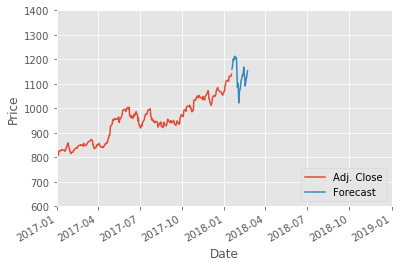

In [60]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle

style.use('ggplot')

#Create & adjust dataframe
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]


#Define forecast column, fill NaNs, shift label column
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

#Let X be the feature array
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X) #Preprocess feature data
X_lately = X[-forecast_out:] 
X = X[:-forecast_out]

df.dropna(inplace=True) #Drop NaNs from dataframe

y = np.array(df['label'])

#Train & test the classifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Confidence', confidence)
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

#Predict and cleanup forecast data
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

#Assign forecast dates
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


#This loop adds the forecast set to the dataframe 
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

#Graphing
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim('2017','2019')
plt.ylim(600,1400)
plt.show()

## Linear Regression

In [2]:
from statistics import mean

xs = np.array([1,2,3,4,5], dtype=np.float64)
ys = np.array([5,4,6,5,6], dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)**2) - mean(xs**2)))
    b = mean(ys) - m*mean(xs)
    return m,b

m,b = best_fit_slope_and_intercept(xs,ys)

print(m,b)

0.3 4.3


In [3]:
regression_line = [(m*x)+b for x in xs]
print(regression_line)

[4.6000000000000023, 4.9000000000000012, 5.2000000000000002, 5.4999999999999991, 5.799999999999998]


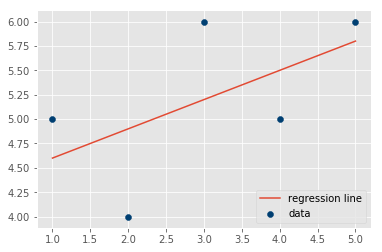

In [4]:
plt.scatter(xs,ys,color='#003F72', label='data')
plt.plot(xs, regression_line, label='regression line')
plt.legend(loc=4)
plt.show()

In [5]:
predict_x = 7
predict_y = (m*predict_x)+b
print(predict_y)

6.4


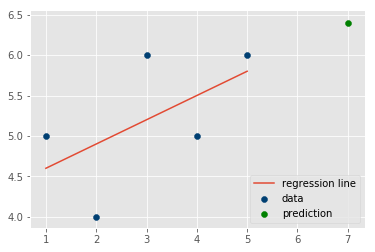

In [6]:
plt.scatter(xs,ys,color='#003F72',label='data')
plt.scatter(predict_x,predict_y,color='g',label='prediction')
plt.plot(xs, regression_line, label='regression line')
plt.legend(loc=4)
plt.show()

In [7]:
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)
    
m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]

r_squared = coefficient_of_determination(ys,regression_line)
print(r_squared)


0.321428571429


SE_r:  1036.88855535
SE_m:  1060.4
r squared:  0.0221722412796


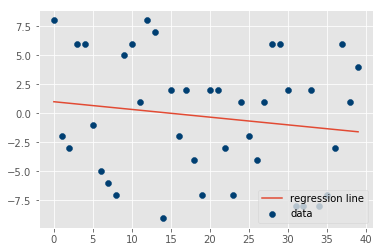

In [8]:
import random

def create_dataset(hm,variance,step=2,correlation=False):
    val = 1
    ys = []
    for i in range(hm):
        y = val + random.randrange(-variance,variance)
        ys.append(y)
        if correlation and correlation == 'pos':
            val+=step
        elif correlation and correlation == 'neg':
            val-=step

    xs = [i for i in range(len(ys))]
    
    return np.array(xs, dtype=np.float64),np.array(ys,dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)

    return m, b


def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]

    squared_error_regr = sum((ys_line - ys_orig) * (ys_line - ys_orig))
    squared_error_y_mean = sum((y_mean_line - ys_orig) * (y_mean_line - ys_orig))

    print('SE_r: ',squared_error_regr)
    print('SE_m: ',squared_error_y_mean)

    r_squared = 1 - (squared_error_regr/squared_error_y_mean)

    return r_squared


xs, ys = create_dataset(40,10,2,correlation=False)
m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]
r_squared = coefficient_of_determination(ys,regression_line)
print('r squared: ',r_squared)

plt.scatter(xs,ys,color='#003F72', label = 'data')
plt.plot(xs, regression_line, label = 'regression line')
plt.legend(loc=4)
plt.show()

## Classification: K Nearest Neighbors

In [9]:
from sklearn import preprocessing, cross_validation, neighbors

In [10]:
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)

In [11]:
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = neighbors.KNeighborsClassifier()

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.971428571429


In [13]:
example_measures = np.array([4,2,1,1,1,2,3,2,1])
example_measures = example_measures.reshape(1, -1)
prediction = clf.predict(example_measures)
print(prediction)

[2]


In [14]:
example_measures = np.array([[4,2,1,1,1,2,3,2,1],[4,4,2,1,3,4,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

[2 2]


Euclidean Distance Theorem:

In [15]:
plot1 = [1,3]
plot2 = [2,5]
euclidean_distance = np.sqrt( (plot1[0]-plot2[0])**2 + (plot1[1]-plot2[1])**2 )
euclidean_distance

2.2360679774997898

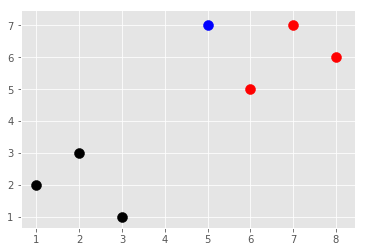

In [30]:
import warnings
from math import sqrt
from collections import Counter

dataset = {'k':[[1,2],[2,3],[3,1]], 'r':[[6,5],[7,7],[8,6]]}
new_features = [5,7]

[[plt.scatter(ii[0],ii[1],s=100,color=i) for ii in dataset[i]] for i in dataset]
plt.scatter(new_features[0], new_features[1], s=100, color='b')

plt.show()


In [26]:
def k_nearest_neighbors(data, predict, k=3):
    if len(data) >= k:
        warnings.warn('K is set to a value less than total voting groups!')
        
    distances = []
    for group in data:
        for features in data[group]:
            euclidean_distance = np.linalg.norm(np.array(features)-np.array(predict))
            distances.append([euclidean_distance,group])

    votes = [i[1] for i in sorted(distances)[:k]]
    vote_result = Counter(votes).most_common(1)[0][0]
    return vote_result

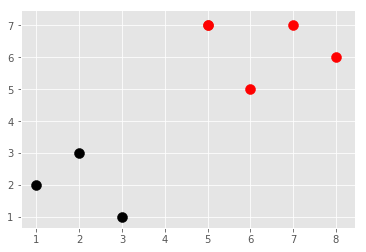

In [27]:
dataset = {'k':[[1,2],[2,3],[3,1]], 'r':[[6,5],[7,7],[8,6]]}
new_features = [5,7]
[[plt.scatter(ii[0],ii[1],s=100,color=i) for ii in dataset[i]] for i in dataset]
# same as:
##for i in dataset:
##    for ii in dataset[i]:
##        plt.scatter(ii[0],ii[1],s=100,color=i)
        
plt.scatter(new_features[0], new_features[1], s=100)

result = k_nearest_neighbors(dataset, new_features)
plt.scatter(new_features[0], new_features[1], s=100, color = result)  
plt.show()

In [31]:
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)
full_data = df.astype(float).values.tolist()

In [32]:
random.shuffle(full_data)
test_size = 0.2
train_set = {2:[], 4:[]}
test_set = {2:[], 4:[]}
train_data = full_data[:-int(test_size*len(full_data))]
test_data = full_data[-int(test_size*len(full_data)):]

In [46]:
for i in train_data:
    train_set[i[-1]].append(i[:-1])

for i in test_data:
    test_set[i[-1]].append(i[:-1])

In [48]:
correct = 0
total = 0

for group in test_set:
    for data in test_set[group]:
        vote = k_nearest_neighbors(train_set, data, k=5)
        if group == vote:
            correct += 1
        total += 1
print('Accuracy:', correct/total)

Accuracy: 0.9496402877697842


## Support  Vector Machine Classification

In [59]:
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors, svm
import pandas as pd

df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?',-99999, inplace=True)
df.drop(['id'], 1, inplace=True)

X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = svm.SVC()

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

example_measures = np.array([[4,2,1,1,1,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

0.942857142857
[2]


Building our own SVM:

In [88]:
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]
        
        # finding values to work with for our ranges.
        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        # no need to keep this memory.
        all_data=None
        
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # starts getting very high cost after this.
                      self.max_feature_value * 0.001]
        
        # extremely expensive
        b_range_multiple = 5
        b_multiple = 5
        latest_optimum = self.max_feature_value*10
        
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]
                            
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
        
    def predict(self,features):
        # classifiction is just:
        # sign(xi.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        # if the classification isn't zero, and we have visualization on, we graph
        if classification != 0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*', c=self.colors[classification])
        else:
            print('featureset',features,'is on the decision boundary')
        return classification
    
    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,color=self.colors[i]) for x in data_dict[i]] for i in data_dict]

        # hyperplane = x.w+b
        # v = x.w+b
        # psv = 1
        # nsv = -1
        # dec = 0
        def hyperplane(x,w,b,v):
            return (-w[0]*x-b+v) / w[1]

        datarange = (self.min_feature_value*0.9,self.max_feature_value*1.1)
        hyp_x_min = datarange[0]
        hyp_x_max = datarange[1]

        # (w.x+b) = 1
        # positive support vector hyperplane
        psv1 = hyperplane(hyp_x_min, self.w, self.b, 1)
        psv2 = hyperplane(hyp_x_max, self.w, self.b, 1)
        self.ax.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'k')

        # (w.x+b) = -1
        # negative support vector hyperplane
        nsv1 = hyperplane(hyp_x_min, self.w, self.b, -1)
        nsv2 = hyperplane(hyp_x_max, self.w, self.b, -1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'k')

        # (w.x+b) = 0
        # positive support vector hyperplane
        db1 = hyperplane(hyp_x_min, self.w, self.b, 0)
        db2 = hyperplane(hyp_x_max, self.w, self.b, 0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')

        plt.show()

In [89]:
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

Optimized a step.
Optimized a step.
Optimized a step.


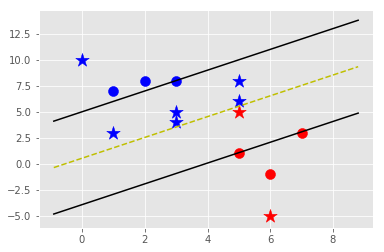

In [90]:
svm = Support_Vector_Machine()
svm.fit(data=data_dict)

predict_us = [[0,10],
              [1,3],
              [3,4],
              [3,5],
              [5,5],
              [5,6],
              [6,-5],
              [5,8]]

for p in predict_us:
    svm.predict(p)

svm.visualize()

## Clustering